# Auto Feature Engineering Workflow Demo

## Content

* [Auto Feature Engineering RUN](#Auto-Feature-Engineering-RUN)
* [Feature Profiling](#Feature-Profiling)
* [Pipeline Plot](#Pipeline-Plot)
* [Feature Importance](#Feature-Importance)

## 1. Introduction

This AutoFE workflow demo shows how to leverage the Auto-Feature-Engineering toolkit (codename:RecDP) to automatically transform raw tabular data to a ready-to-train data with enriched usefull new features, while significantly improve developer productivity and end-to-end data prepration performance.
![auto feature engineering](recdp_autofe_overview.jpg)

AutoFE workflows uses RecDP to: 

(1) Automatically profile the dataset, infer data type of each input columns  
(2) Determines the proper feature engineering primitives with infered data type  
(3) Generates data preparation pipelines with chained operators  
(4) Generates DAG for operations  
(5) Execute DAG on different engines  
(6) Feature importance analsyis  

## 2. Auto Feature Engineering Workflow Demo

### Step 1: Configuration file 
edit `workflow.yaml`, supported configurations are listed in table

| Name            | Description   |
| --------------- | ------------- |
| dataset_path | set dataset directory |
| target_label | specify target lable of dataset|
| engine_type | config auto feature engineering engine type, support pandas and spark |

In [1]:
!cat workflow.yaml

dataset_path: ./raw_data/card_transaction.v1.csv
target_label: 'Is Fraud?'
engine_type: pandas

In [2]:
data = load_data()
data

Read /home/vmagent/app/workspace/./raw_data/card_transaction.v1.csv started ...
Read /home/vmagent/app/workspace/./raw_data/card_transaction.v1.csv took 33.024780344218016 sec


,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,$-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386896,1999,1,2020,2,27,22:24,$54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386897,1999,1,2020,2,28,07:43,$59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No
24386898,1999,1,2020,2,28,20:10,$43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No


In [3]:
train_data = data[data['Year'] < 2018].reset_index(drop=True)
valid_data = data[data['Year'] == 2018].reset_index(drop=True)
test_data = data[data['Year'] > 2018].reset_index(drop=True)

In [4]:
train_data

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20604842,1999,1,2017,12,31,07:39,$68.68,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No
20604843,1999,1,2017,12,31,11:16,$53.88,Chip Transaction,-7389834768703789874,Phoenix,AZ,85009.0,7538,NaN,No
20604844,1999,1,2017,12,31,11:38,$73.57,Chip Transaction,-2472481739355111587,Phoenix,AZ,85009.0,7538,NaN,No
20604845,1999,1,2017,12,31,12:27,$8.12,Online Transaction,6455213054093379528,ONLINE,NaN,NaN,5815,NaN,No


### Step 2: Kick off AuoFE workflow 

In [5]:
from pyrecdp.autofe import AutoFE

pipeline = AutoFE(dataset=train_data, label=target_label, time_series = 'Day')
transformed_train_df = pipeline.fit_transform()

valid_pipeline = AutoFE.clone_pipeline(pipeline, valid_data)
transformed_valid_df = valid_pipeline.transform()

test_pipeline = AutoFE.clone_pipeline(pipeline, test_data)
transformed_test_df = test_pipeline.transform()

AutoFE started to profile data


TypeConvertFeatureGenerator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1189.20it/s]


AutoFE started to create data pipeline
We exclude some Feature Engineer Generator as listed, you can use 'include_op = ["XXXFeatureGenerator"]'  to re-add them, exclude_op list ['TargetEncodeFeatureGenerator']


/usr/local/lib/python3.10/dist-packages/pyrecdp/core/dataframe.py:19: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'may_sample' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  def may_sample(df, nrows = 100000):
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 199096.71it/s]


Feature List generated, using analyzed feature tags to create data pipeline


DropUselessFeatureGenerator: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 826.64it/s]


AutoFE started to fit_transform data
execute with pandas started ...
execute DataFrame started ...
  execute DataFrame took 2.6832463536411524 sec
execute type_infer started ...
  execute type_infer took 5.989440640434623 sec
execute time_series_infer started ...
  execute time_series_infer took 8.516013622283936e-06 sec
execute string_to_number started ...
Amount [('Amount__string_to_number', <class 'pyrecdp.primitives.generators.feature_transform.StringToNumber'>)]
  execute string_to_number took 26.475773755460978 sec
execute astype started ...
User [('User', <class 'pyrecdp.primitives.generators.type.IntTransformer'>)]
Card [('Card', <class 'pyrecdp.primitives.generators.type.IntTransformer'>)]
Year [('Year', <class 'pyrecdp.primitives.generators.type.IntTransformer'>)]
Month [('Month', <class 'pyrecdp.primitives.generators.type.IntTransformer'>)]
Day [('Day', <class 'pyrecdp.primitives.generators.type.IntTransformer'>)]
Merchant Name [('Merchant Name', <class 'pyrecdp.primitives.g

OnehotEncode: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.66s/it]


  execute onehot_encode took 12.629370361566544 sec
execute list_onehot_encode started ...


ListOnehotEncode: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.96s/it]


  execute list_onehot_encode took 43.78560215048492 sec
execute categorify started ...


Categorify: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.54s/it]


  execute categorify took 23.29580421745777 sec
execute group_categorify started ...


GroupCategorify: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:30<00:00,  2.82s/it]


  execute group_categorify took 42.965254763141274 sec
execute categorify started ...


Categorify: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.38s/it]


  execute categorify took 30.21593920700252 sec
execute count_encode started ...


CountEncode: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:00<00:00,  2.52s/it]


  execute count_encode took 68.20907056890428 sec
execute rename started ...
  execute rename took 15.036789229139686 sec
execute drop started ...
  execute drop took 4.037968432530761 sec
execute DataFrame started ...
  execute DataFrame took 2.666190266609192e-05 sec
execute lightgbm started ...


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 22743, number of negative: 18521620
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.520934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8229
[LightGBM] [Info] Number of data points in the train set: 18544363, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001226 -> initscore=-6.702437
[LightGBM] [Info] Start training from score -6.702437
[100]	valid_0's auc: 0.965475
  execute lightgbm took 46.42636171914637 sec
execute with pandas took 348.49195898137987 sec
execute with pandas started ...
execute DataFrame started ...
  execute DataFrame took 0.15072613023221493 sec
execute type_infer started ...
  execute type_infer took 0.09974788874387741 sec
execute time_series_infer started ...
  execute time_series_infer took 1.1976808309555054e-05 sec
execute string_to_n

OnehotEncode: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.93s/it]


  execute onehot_encode took 15.710102409124374 sec
execute list_onehot_encode started ...


ListOnehotEncode: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.25s/it]


  execute list_onehot_encode took 19.11058635637164 sec
execute categorify started ...


Categorify: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.66s/it]


  execute categorify took 17.18998370692134 sec
execute group_categorify started ...


GroupCategorify: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:28<00:00,  2.57s/it]


  execute group_categorify took 29.78528548963368 sec
execute categorify started ...


Categorify: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.47s/it]


  execute categorify took 19.07645934820175 sec
execute count_encode started ...


CountEncode: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:21<00:00,  1.10it/s]


  execute count_encode took 23.105682138353586 sec
execute rename started ...
  execute rename took 1.2808195054531097 sec
execute drop started ...
  execute drop took 0.3382793068885803 sec
execute with pandas took 129.9495365396142 sec
execute with pandas started ...
execute DataFrame started ...
  execute DataFrame took 0.17810492031276226 sec
execute type_infer started ...
  execute type_infer took 0.1025854591280222 sec
execute time_series_infer started ...
  execute time_series_infer took 8.169561624526978e-06 sec
execute string_to_number started ...
Amount [['Amount__string_to_number', ['pyrecdp.primitives.generators.feature_transform', 'StringToNumber']]]
  execute string_to_number took 2.7114114686846733 sec
execute astype started ...
User [['User', ['pyrecdp.primitives.generators.type', 'IntTransformer']]]
Card [['Card', ['pyrecdp.primitives.generators.type', 'IntTransformer']]]
Year [['Year', ['pyrecdp.primitives.generators.type', 'IntTransformer']]]
Month [['Month', ['pyrec

OnehotEncode: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.78s/it]


  execute onehot_encode took 17.62602687627077 sec
execute list_onehot_encode started ...


ListOnehotEncode: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.46s/it]


  execute list_onehot_encode took 21.448780139908195 sec
execute categorify started ...


Categorify: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.40s/it]


  execute categorify took 19.158766467124224 sec
execute group_categorify started ...


GroupCategorify: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.89s/it]


  execute group_categorify took 33.59953934699297 sec
execute categorify started ...


Categorify: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.85s/it]


  execute categorify took 21.207000767812133 sec
execute count_encode started ...


CountEncode: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:24<00:00,  1.03s/it]


  execute count_encode took 26.191638411954045 sec
execute rename started ...
  execute rename took 1.5085009392350912 sec
execute drop started ...
  execute drop took 0.40141013264656067 sec
execute with pandas took 145.8634836524725 sec


In [7]:
transformed_train_df.to_parquet("transformed_train_df_day.parquet")
transformed_valid_df.to_parquet("transformed_valid_df_day.parquet")
transformed_test_df.to_parquet("transformed_test_df_day.parquet")

## 3. AutoFE Deep dive 

### 3.1 Feature Profiling
AutoFE provides feature profiler to analyze the feature distribution and identify insights of feature.

In [ ]:
pipeline.profile(engine_type)

## 3.2 Pipeline Plot

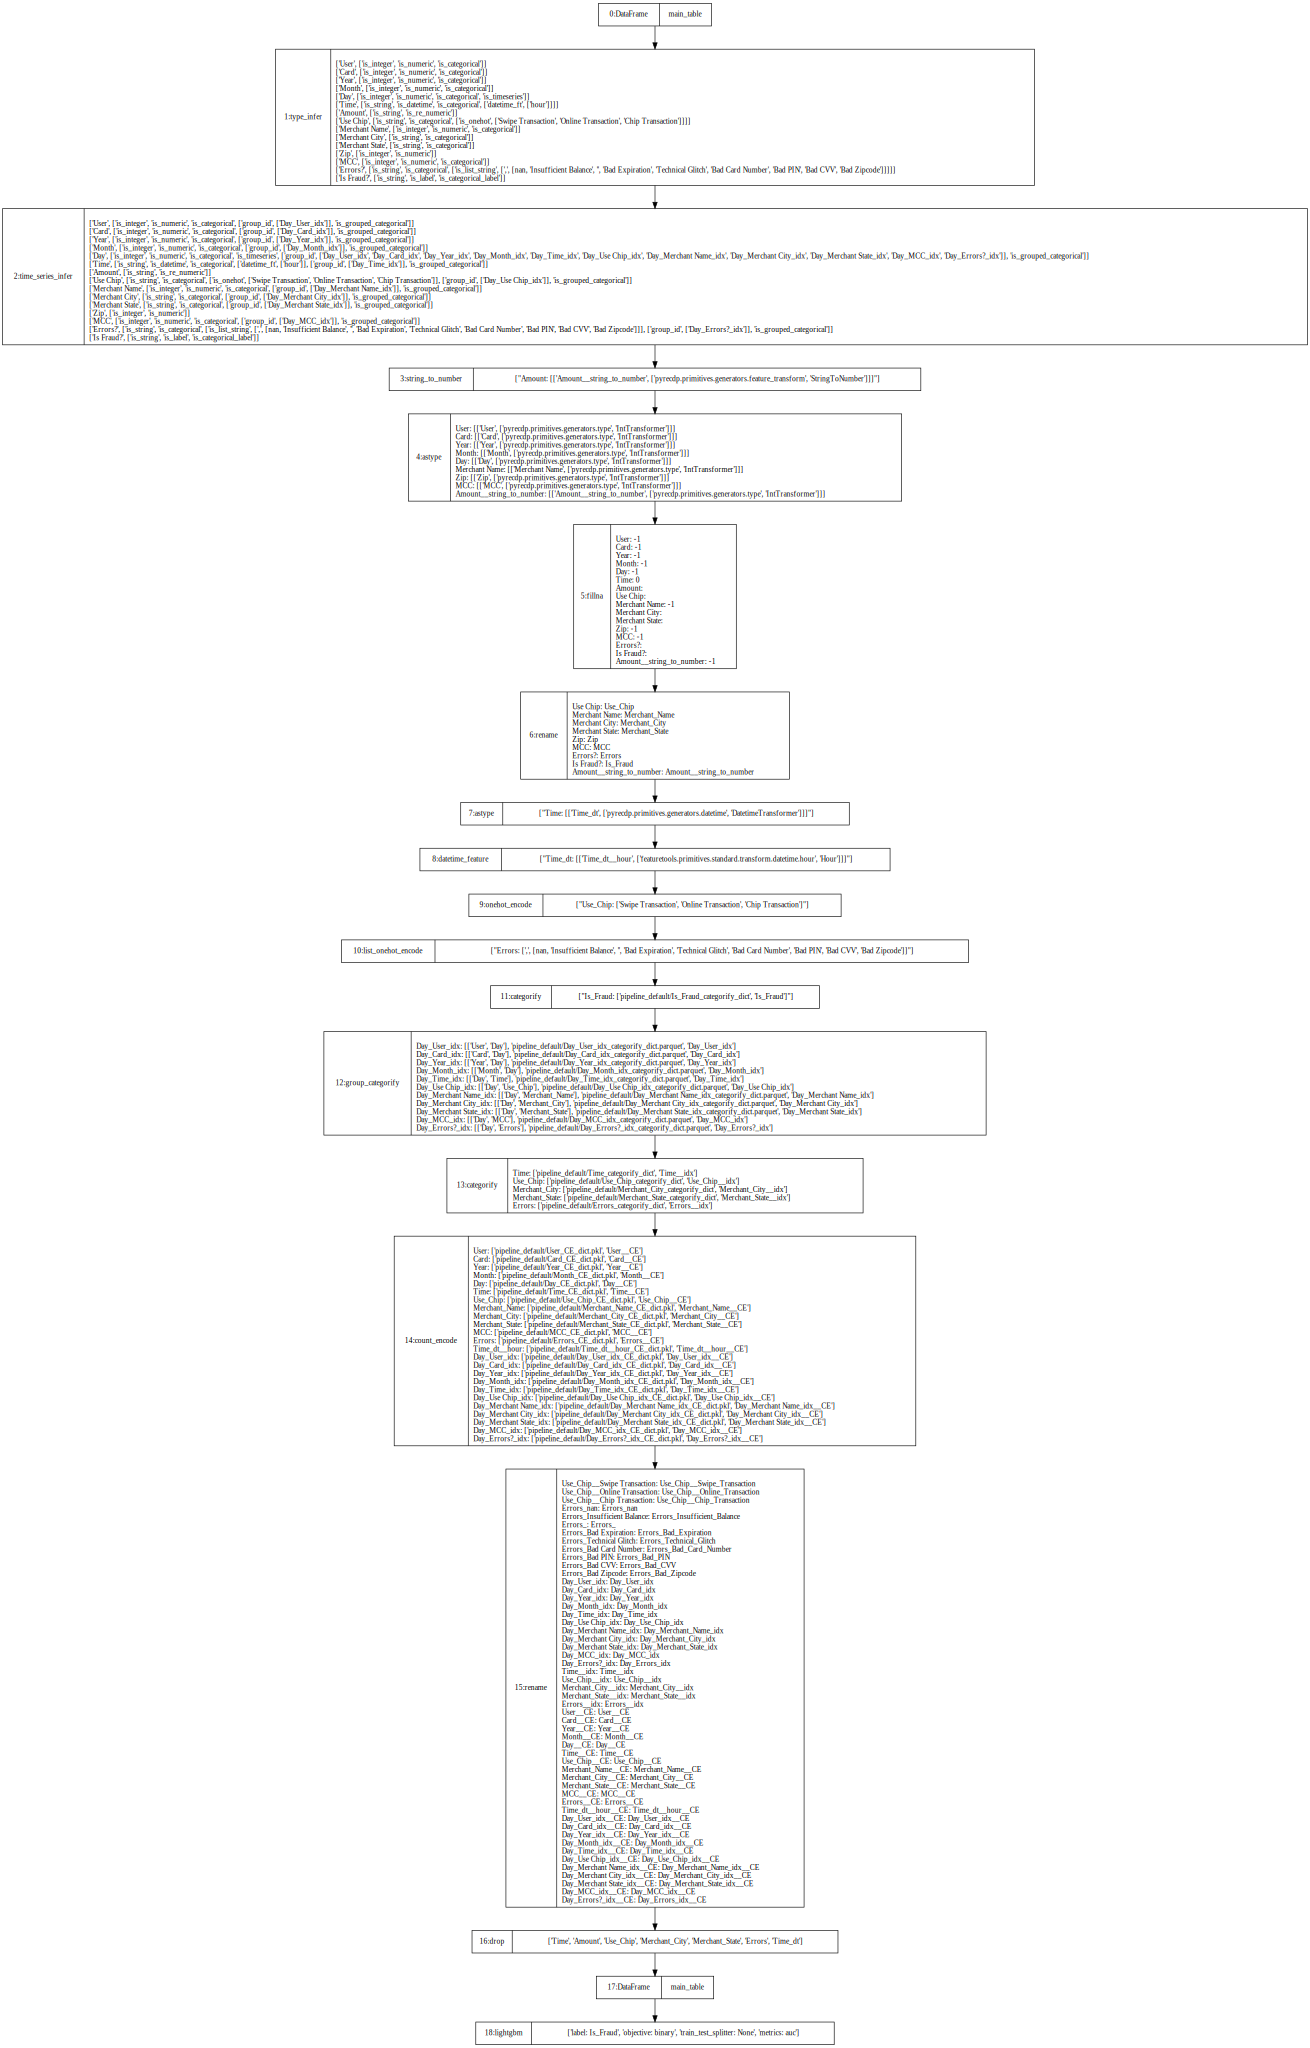

In [7]:
pipeline.plot()

## 3.3 Feature Importance

<Axes: >

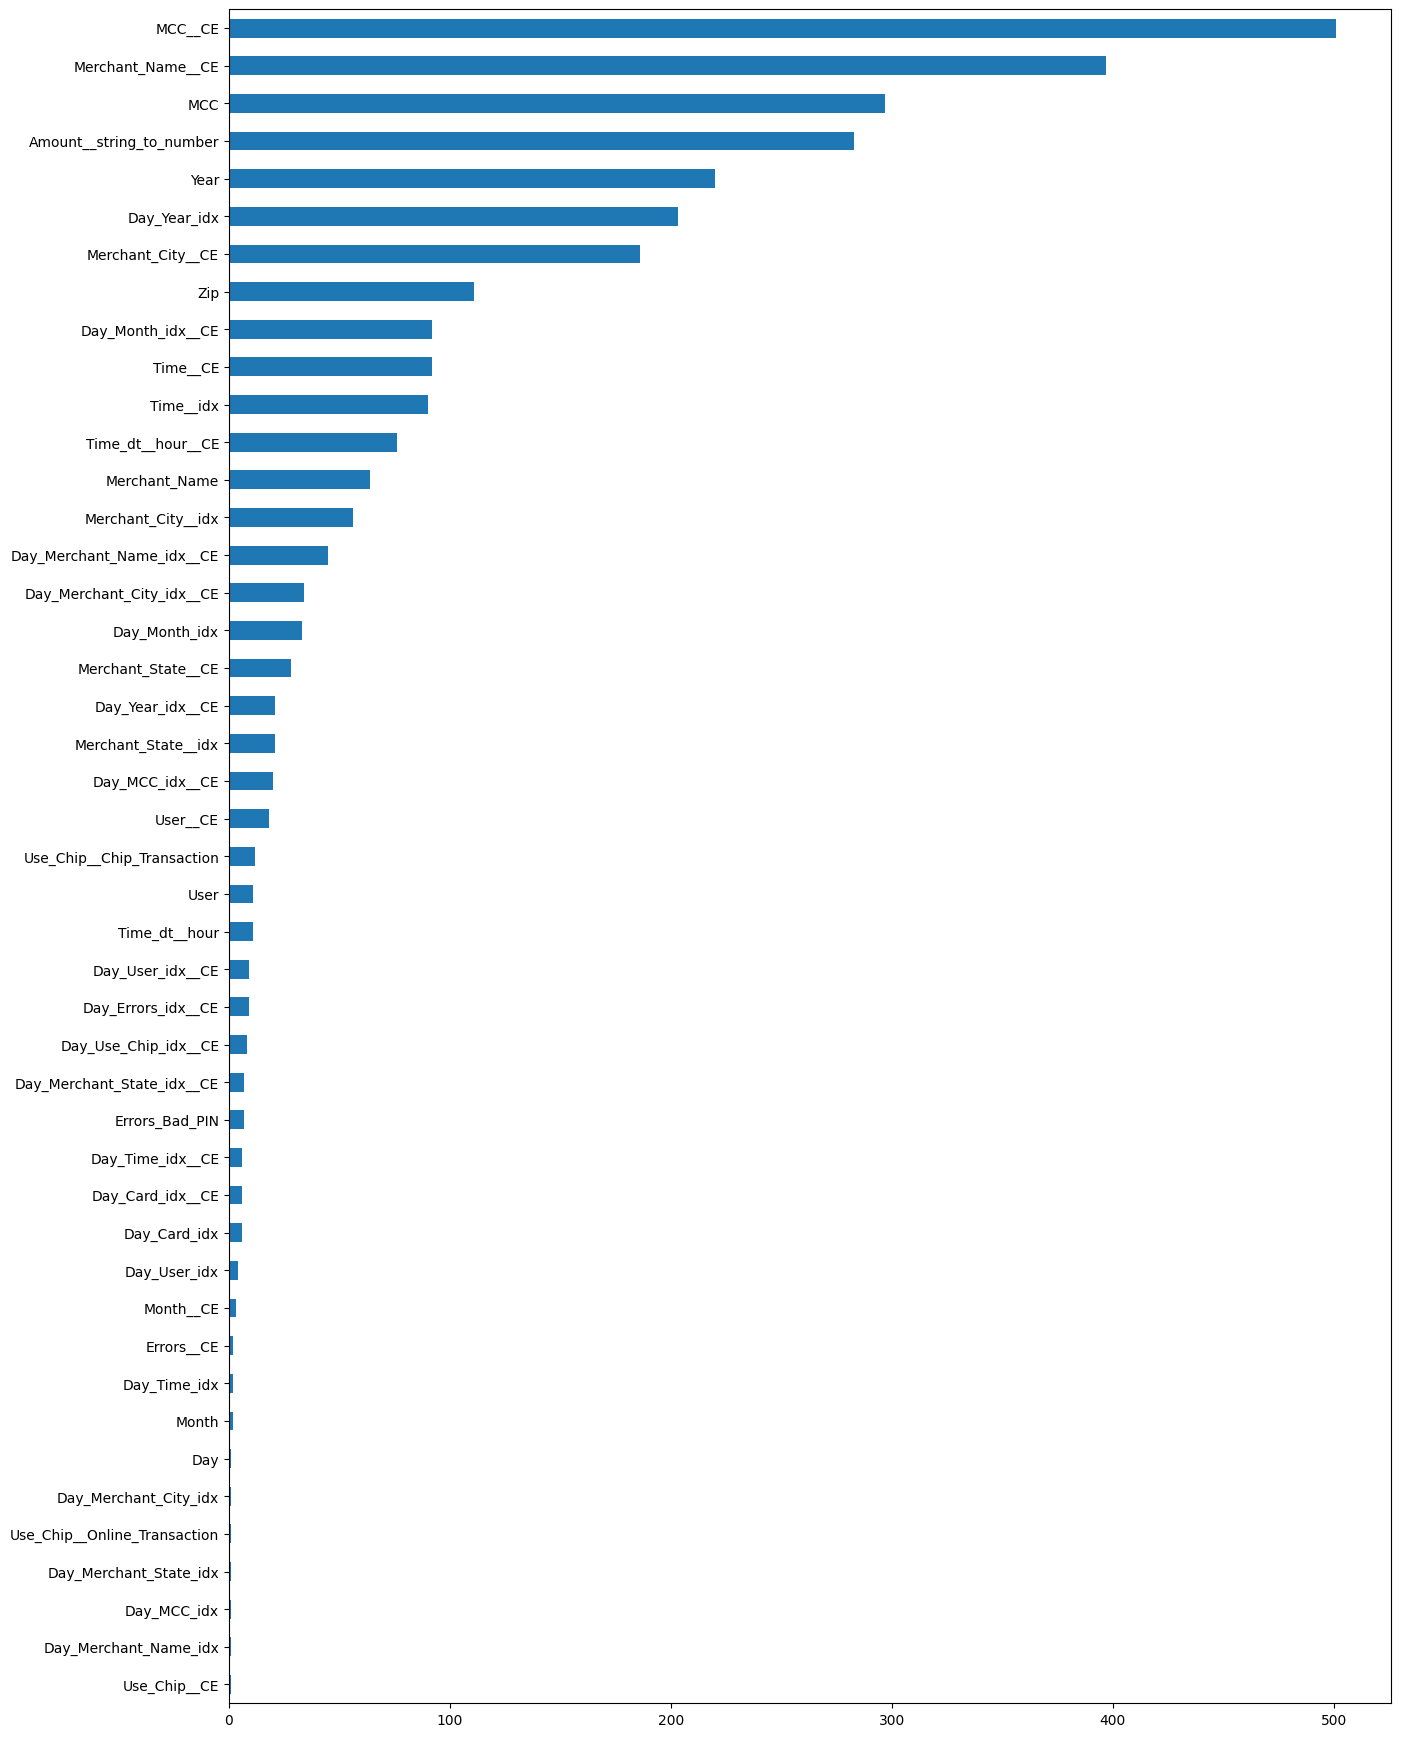

In [8]:
pipeline.feature_importance()

## 4. Model training

In [ ]:
! pip install xgboost

In [6]:
# # test with XGBoost
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
import xgboost as xgb  

target_label = 'Is_Fraud'
model_params = {
    'eval_metric': 'aucpr',
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'random_state': 42,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'min_child_weight': 9,
}
training_params = {
    'num_boost_round': 1000,
    'verbose_eval': 100,
}

exclude_features = []
features_train = [i for i in transformed_valid_df.columns if i not in [target_label] + exclude_features]

dtrain = xgb.DMatrix(data=transformed_train_df[features_train], label=transformed_train_df[target_label])
dvalid = xgb.DMatrix(data=transformed_valid_df[features_train], label=transformed_valid_df[target_label])
dtest = xgb.DMatrix(data=transformed_test_df[features_train], label=transformed_test_df[target_label])

watch_list = [(dtrain,'train'), (dvalid, 'eval'), (dtest, 'test')]
#watch_list = [(dtrain,'train'), (dtest, 'test')]
with Timer("XGBoost training"):
    model = xgb.train(model_params, **training_params, dtrain=dtrain, evals=watch_list)

with Timer("XGBoost test"):
    probs = model.predict(dtest)
    precision, recall, _ = precision_recall_curve(transformed_test_df[target_label], probs)
    test_result = auc(recall, precision)
print(f"testing results aucpr on test set is {test_result}")

XGBoost training started ...
[0]	train-aucpr:0.36088	eval-aucpr:0.17358	test-aucpr:0.12966
[100]	train-aucpr:0.73810	eval-aucpr:0.73312	test-aucpr:0.67325
[200]	train-aucpr:0.80110	eval-aucpr:0.88399	test-aucpr:0.82050
[300]	train-aucpr:0.83101	eval-aucpr:0.91006	test-aucpr:0.84560
[400]	train-aucpr:0.84765	eval-aucpr:0.91060	test-aucpr:0.84745
[500]	train-aucpr:0.86105	eval-aucpr:0.92446	test-aucpr:0.87223
[600]	train-aucpr:0.87171	eval-aucpr:0.92893	test-aucpr:0.88008
[700]	train-aucpr:0.88173	eval-aucpr:0.92999	test-aucpr:0.88120
[800]	train-aucpr:0.89142	eval-aucpr:0.92815	test-aucpr:0.87653
[900]	train-aucpr:0.89965	eval-aucpr:0.93022	test-aucpr:0.87934
[999]	train-aucpr:0.90681	eval-aucpr:0.93160	test-aucpr:0.88154
XGBoost training took 1175.042554659769 sec
XGBoost test started ...
XGBoost test took 1.2980223800987005 sec
testing results aucpr on test set is 0.8815356998504907


In [8]:
print(len(features_train), features_train)

60 ['User', 'Card', 'Year', 'Month', 'Day', 'Merchant_Name', 'Zip', 'MCC', 'Amount__string_to_number', 'Time_dt__hour', 'Use_Chip__Chip_Transaction', 'Use_Chip__Online_Transaction', 'Use_Chip__Swipe_Transaction', 'Errors_Bad_CVV', 'Errors_Bad_Card_Number', 'Errors_Bad_Expiration', 'Errors_Bad_PIN', 'Errors_Bad_Zipcode', 'Errors_Insufficient_Balance', 'Errors_Technical_Glitch', 'Day_Card_idx', 'Day_Month_idx', 'Day_Year_idx', 'Day_User_idx', 'Day_Use_Chip_idx', 'Day_MCC_idx', 'Day_Time_idx', 'Day_Errors_idx', 'Day_Merchant_State_idx', 'Day_Merchant_City_idx', 'Day_Merchant_Name_idx', 'Time__idx', 'Use_Chip__idx', 'Merchant_State__idx', 'Errors__idx', 'Merchant_City__idx', 'Merchant_City__CE', 'Time__CE', 'Use_Chip__CE', 'Merchant_State__CE', 'Errors__CE', 'Card__CE', 'Day__CE', 'Month__CE', 'User__CE', 'Year__CE', 'Time_dt__hour__CE', 'Day_Card_idx__CE', 'MCC__CE', 'Day_Use_Chip_idx__CE', 'Day_Month_idx__CE', 'Day_User_idx__CE', 'Day_Year_idx__CE', 'Day_Errors_idx__CE', 'Day_Merchant_St

In [9]:
# # # test with XGBoost
# from sklearn.metrics import average_precision_score, precision_recall_curve, auc
# import xgboost as xgb  

# target_label = 'Is_Fraud'
# model_params = {
#     'eval_metric': 'aucpr',
#     'objective': 'binary:logistic',
#     'tree_method': 'hist',
#     'random_state': 42,
#     'learning_rate': 0.05,
#     'max_depth': 6,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'min_child_weight': 9,
# }
# training_params = {
#     'num_boost_round': 1000,
#     'verbose_eval': 100,
# }

# exclude_features = []
# features_train = [i for i in transformed_valid_df.columns if i not in [target_label] + exclude_features]

# dtrain = xgb.DMatrix(data=transformed_train_df[features_train], label=transformed_train_df[target_label])
# dvalid = xgb.DMatrix(data=transformed_valid_df[features_train], label=transformed_valid_df[target_label])
# dtest = xgb.DMatrix(data=transformed_test_df[features_train], label=transformed_test_df[target_label])

# watch_list = [(dtrain,'train'), (dvalid, 'eval'), (dtest, 'test')]
# #watch_list = [(dtrain,'train'), (dtest, 'test')]
# with Timer("XGBoost training"):
#     model = xgb.train(model_params, **training_params, dtrain=dtrain, evals=watch_list)

# with Timer("XGBoost test"):
#     probs = model.predict(dtest)
#     precision, recall, _ = precision_recall_curve(transformed_test_df[target_label], probs)
#     test_result = auc(recall, precision)
# print(f"testing results aucpr on test set is {test_result}")

XGBoost training started ...
[0]	train-aucpr:0.42491	eval-aucpr:0.40767	test-aucpr:0.32711
[100]	train-aucpr:0.74842	eval-aucpr:0.75722	test-aucpr:0.68287
[200]	train-aucpr:0.80069	eval-aucpr:0.90994	test-aucpr:0.85136
[300]	train-aucpr:0.83219	eval-aucpr:0.90850	test-aucpr:0.83773
[400]	train-aucpr:0.84967	eval-aucpr:0.91229	test-aucpr:0.84552
[500]	train-aucpr:0.86411	eval-aucpr:0.91515	test-aucpr:0.85264
[600]	train-aucpr:0.87497	eval-aucpr:0.91679	test-aucpr:0.85181
[700]	train-aucpr:0.88579	eval-aucpr:0.91757	test-aucpr:0.85581
[800]	train-aucpr:0.89461	eval-aucpr:0.91991	test-aucpr:0.86272
[900]	train-aucpr:0.90297	eval-aucpr:0.91659	test-aucpr:0.85780
[999]	train-aucpr:0.91027	eval-aucpr:0.91373	test-aucpr:0.84964
XGBoost training took 1140.5190069247037 sec
XGBoost test started ...
XGBoost test took 1.2858655955642462 sec
testing results aucpr on test set is 0.8496025058070872


# 5. Performance Evaluation

Auto Feature Engineering only required 3 lines of configuration, Comparing with Manual written codes, it significantly reduces the feature engineering complexity

| Name            | Line of Codes / config   | Process Time | Num Feature | Feature Engineering Methods |
| --------------- | ------------- | ------------- | ------------- | ------------- |
| Manual Written codes | [~ 93 lines](https://github.com/intel-sandbox/graph_platform/blob/main/workflows/fraud_detection.ipynb) | ~ 176 secs (pandas) | 26 | Data Standardize, numerical_convert, Data Split, categorify, concat, min_max_scaling, onehot_encode, multi_hot_encoding, target_encoding |
| Distributed ML workflow | [~ 50 lines](https://github.com/intel/recommender-system-with-classical-ml/blob/main/applications/fraud_detection/data-preprocessing.yaml)| TBD | 26 | Data Standardize, numerical_convert, Data Split, categorify, concat, min_max_scaling, onehot_encode, multi_hot_encoding, target_encoding |
| AutoFE workflow | 3 lines | ~ 200 secs (pandas) | 33 | Data Standardize, numerical_convert, categorify, onehot_encode, multi_hot_encoding, target_encoding |